# SMS Spam Classification

In [1]:
import nltk
import pickle
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
warnings.filterwarnings("ignore")

In [3]:
sns.set_style("whitegrid")
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

In [4]:
try:
    path = r'../venv/nltk_data'
    nltk.download(
        ['punkt', 'stopwords', 'punkt_tab', 'averaged_perceptron_tagger'], 
        download_dir=path
    )
    nltk.data.path.append(path)
    print('Download successful.')
except Exception as e:
    print(f'An error occurred while downloading NLTK resources: {e}')

Download successful.


[nltk_data] Downloading package punkt to ../venv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ../venv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to ../venv/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     ../venv/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
df = pd.read_csv('../data/spam.csv',  encoding='ISO-8859-1')

In [6]:
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [8]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [9]:
df.rename(columns={'v1':'target','v2':'text'}, inplace=True)

In [10]:
df.head(5)

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
print(f'Duplicated Count: {df.duplicated().sum()}\n{'-'*30}')
print(f'Null Count:\n{df.isnull().sum()}')

Duplicated Count: 403
------------------------------
Null Count:
target    0
text      0
dtype: int64


In [12]:
df = df.drop_duplicates(keep='first')
print(f'Duplicated Count: {df.duplicated().sum()}')

Duplicated Count: 0


## Exploratory Data Analysis

In [13]:
df.head(5)

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Target 

In [14]:
target_count = df['target'].value_counts()
target_count

target
ham     4516
spam     653
Name: count, dtype: int64

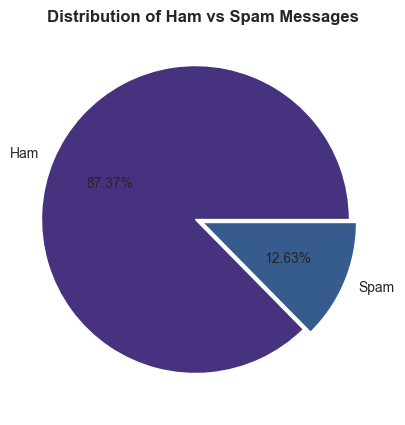

In [15]:
plt.figure(figsize=(5, 5))

plt.pie(
    target_count, 
    labels=['Ham', 'Spam'], 
    autopct="%0.2f%%",
    explode=(0.05, 0)
)
plt.title('Distribution of Ham vs Spam Messages')
plt.show()

### Features

In [16]:
df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['sent_count'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [17]:
df.head()

,target,text,char_count,word_count,sent_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [18]:
df_count = ['char_count', 'word_count', 'sent_count']
df_ham = df[df['target'] == 'ham']
df_spam = df[df['target'] == 'spam']

In [19]:
df[df_count].describe().style.format(precision=2)

,char_count,word_count,sent_count
count,5169.00,5169.00,5169.00
mean,78.98,18.46,1.97
std,58.24,13.32,1.45
min,2.00,1.00,1.00
25%,36.00,9.00,1.00
50%,60.00,15.00,1.00
75%,117.00,26.00,2.00
max,910.00,220.00,38.00


In [20]:
df_spam[df_count].describe().style.format(precision=2)

,char_count,word_count,sent_count
count,653.00,653.00,653.00
mean,137.89,27.67,2.97
std,30.14,7.01,1.49
min,13.00,2.00,1.00
25%,132.00,25.00,2.00
50%,149.00,29.00,3.00
75%,157.00,32.00,4.00
max,224.00,46.00,9.00


In [21]:
df_ham[df_count].describe().style.format(precision=2)

,char_count,word_count,sent_count
count,4516.00,4516.00,4516.00
mean,70.46,17.12,1.82
std,56.36,13.49,1.38
min,2.00,1.00,1.00
25%,34.00,8.00,1.00
50%,52.00,13.00,1.00
75%,90.00,22.00,2.00
max,910.00,220.00,38.00


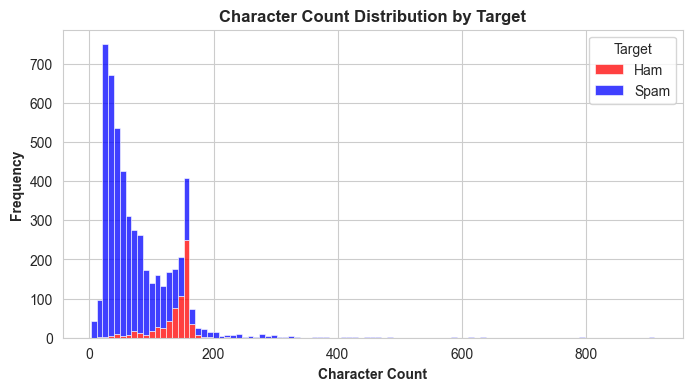

In [22]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='char_count', hue='target', palette={'ham': 'blue', 'spam': 'red'}, multiple='stack')
plt.title('Character Count Distribution by Target')
plt.legend(title='Target', labels=['Ham', 'Spam'])
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

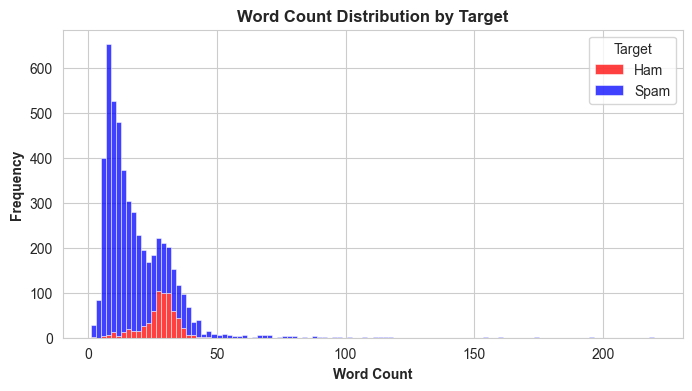

In [23]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='word_count', hue='target', palette={'ham': 'blue', 'spam': 'red'}, multiple='stack')
plt.title('Word Count Distribution by Target')
plt.legend(title='Target', labels=['Ham', 'Spam'])
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

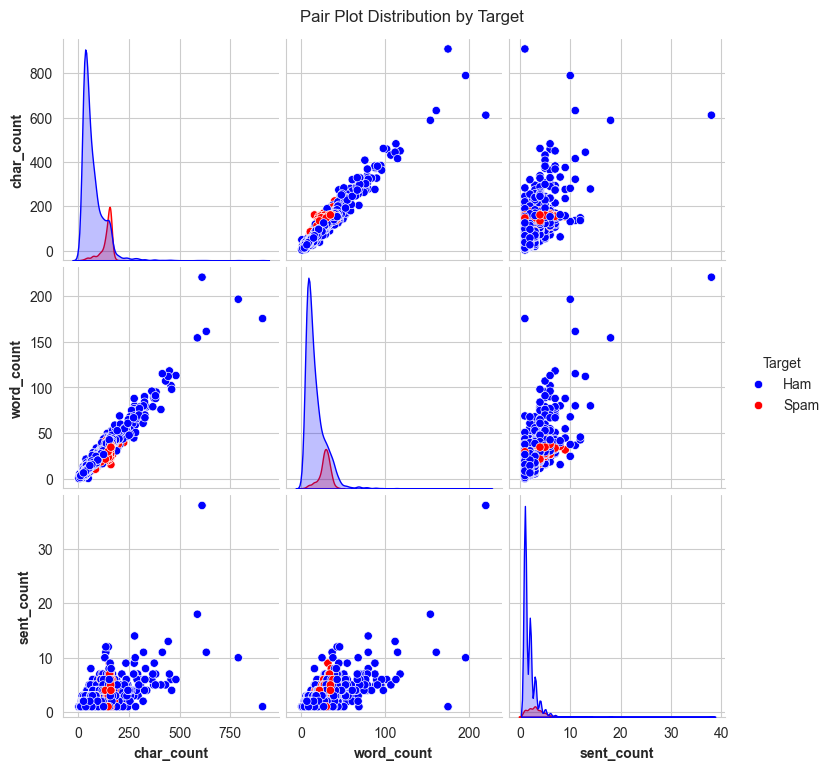

In [24]:
palette = {'ham': 'blue', 'spam': 'red'}

pair_plot = sns.pairplot(df, hue='target', palette=palette)
pair_plot.fig.suptitle('Pair Plot Distribution by Target', y=1.02)

legend = pair_plot._legend
legend.set_title("Target")
legend.texts[0].set_text("Ham")
legend.texts[1].set_text("Spam")
plt.show()

In [25]:
temp = df.assign(target=df['target'].apply(lambda x: 1 if x == 'spam' else 0))
temp = temp[['target'] + [col for col in temp.columns if col != 'target']]
correlation_matrix = temp.corr(numeric_only=True)
correlation_matrix

,target,char_count,word_count,sent_count
target,1.000000,0.384717,0.262912,0.263939
char_count,0.384717,1.000000,0.965760,0.624139
word_count,0.262912,0.965760,1.000000,0.679971
sent_count,0.263939,0.624139,0.679971,1.000000


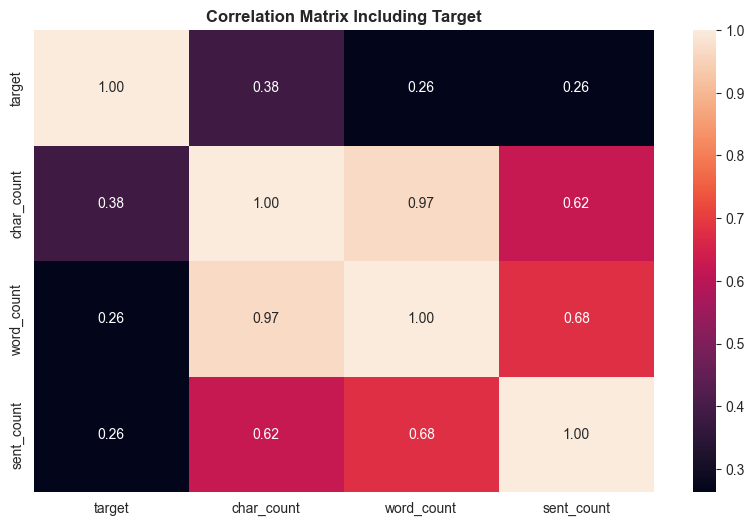

In [26]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix Including Target')
plt.show()

In [27]:
df.sample(5)

,target,text,char_count,word_count,sent_count
1866,ham,Or Ì_ go buy wif him then i meet Ì_ later can?,46,13,1
3670,ham,Yup. Thk of u oso boring wat.,29,9,2
1403,ham,cool. We will have fun practicing making babies!,48,10,2
4456,ham,Aight should I just plan to come up later toni...,50,11,1
143,ham,I know you are. Can you pls open the back?,42,12,2


## Data Preprocessing

- Lowercasing
- Tokenization
- Removing Special Characters
- Removing Punctuation & Stop Words
- Stemming

In [28]:
def transform_text(text):
    # Convert to lowercase and tokenize
    tokens = nltk.word_tokenize(text.lower())
    # Filter out non-alphanumeric tokens and stop words, then apply stemming
    filtered_stemmed = [
        ps.stem(token) 
        for token in tokens 
        if token.isalnum() and token not in stopwords.words('english') and token not in string.punctuation
    ]
    return " ".join(filtered_stemmed)

In [29]:
ps = PorterStemmer()

In [30]:
transform_text("I'm gonna be home soon and I don't want to talk about this stuff anymore tonight.")

'gon na home soon want talk stuff anymor tonight'

In [31]:
df['transformed_text'] = df['text'].apply(transform_text)

In [32]:
df.head()

,target,text,char_count,word_count,sent_count,transformed_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


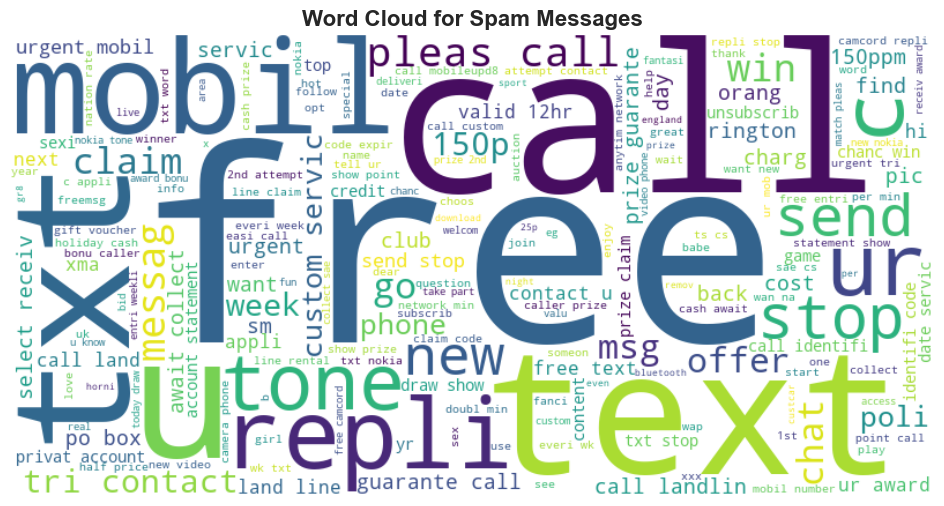

In [33]:
spam_text = df[df['target'] == 'spam']['transformed_text'].str.cat(sep=" ")
spam_word_count = WordCloud(width=800, height=400, background_color="white").generate(spam_text)

plt.figure(figsize=(15, 6))
plt.imshow(spam_word_count, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages', fontsize=16)
plt.axis("off")
plt.show()

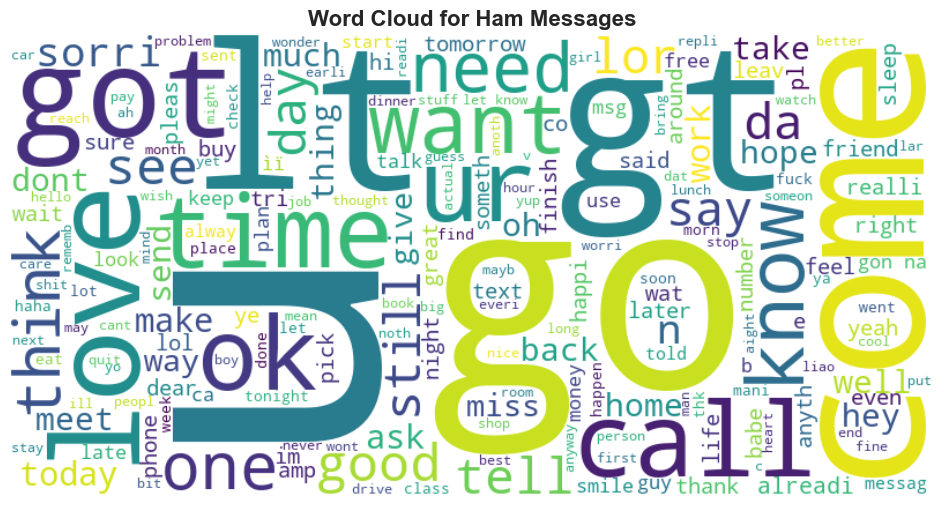

In [34]:
ham_text = df[df['target'] == 'ham']['transformed_text'].str.cat(sep=" ")
ham_word_count = WordCloud(width=800, height=400, background_color="white").generate(ham_text)

plt.figure(figsize=(15, 6))
plt.imshow(ham_word_count, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages', fontsize=16)
plt.axis("off")
plt.show()

In [35]:
df.head()

,target,text,char_count,word_count,sent_count,transformed_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [36]:
ham_corpus = [word for x in df[df['target'] == 'ham']['transformed_text'] for word in x.split()]
spam_corpus = [word for x in df[df['target'] == 'spam']['transformed_text'] for word in x.split()]

In [37]:
print(f'Ham Corpus Count: {len(ham_corpus)}')
print(f'Spam Corpus Count: {len(spam_corpus)}')

Ham Corpus Count: 35404
Spam Corpus Count: 9939


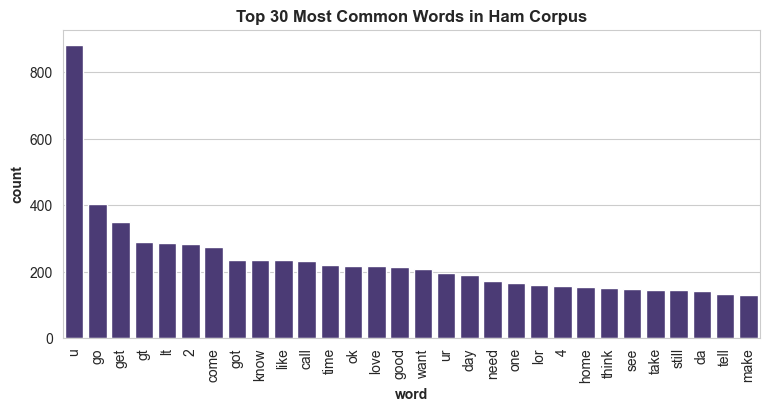

In [38]:
ham_word_counts = Counter(ham_corpus).most_common(30)
ham_word_counts_df = pd.DataFrame(ham_word_counts, columns=['word', 'count'])

sns.barplot(x='word', y='count', data=ham_word_counts_df)
plt.title('Top 30 Most Common Words in Ham Corpus')
plt.xticks(rotation='vertical')
plt.show()

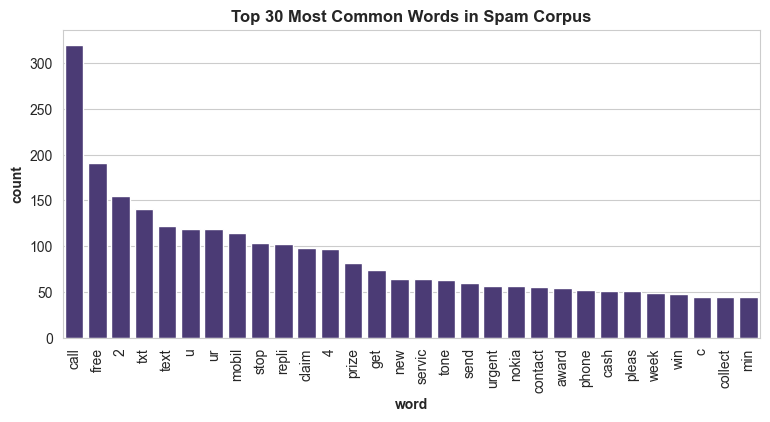

In [39]:
spam_word_counts = Counter(spam_corpus).most_common(30)
spam_word_counts_df = pd.DataFrame(spam_word_counts, columns=['word', 'count'])

sns.barplot(x='word', y='count', data=spam_word_counts_df)
plt.title('Top 30 Most Common Words in Spam Corpus')
plt.xticks(rotation='vertical')
plt.show()

## Machine Learning

In [40]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier

In [41]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [42]:
df.sample(5)

,target,text,char_count,word_count,sent_count,transformed_text
697,0,meet you in corporation st outside gap Û_ you...,78,17,1,meet corpor st outsid gap see mind work
5277,0,"Best msg: It's hard to be with a person, when ...",168,44,1,best msg hard person u know one step foward ma...
4942,0,Check mail.i have mailed varma and kept copy t...,95,15,1,check mail varma kept copi regard allah
756,0,Cant think of anyone with * spare room off * t...,59,14,1,cant think anyon spare room top head
3967,0,Did u turn on the heater? The heater was on an...,73,23,2,u turn heater heater set lt gt degre


In [43]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [44]:
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [45]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [47]:
print(f'Features Shape: {X.shape}')
print(f'Features Shape: {y.shape}')

Features Shape: (5169, 3000)
Features Shape: (5169,)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [49]:
mnb = MultinomialNB()

mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f'Precison Score: {precision_score(y_test, y_pred)}')

Accuracy Score: 0.9709864603481625
Precison Score: 1.0


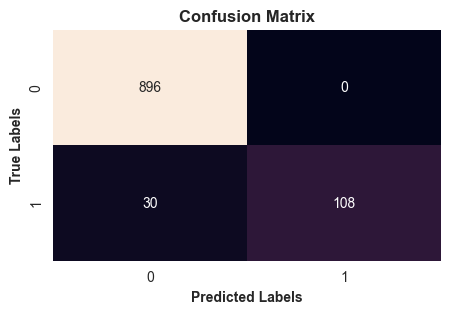

In [50]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(pd.DataFrame(cm), annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [51]:
models = {
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SupportVectorClassifier': SVC(kernel='sigmoid', gamma=1.0),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5),
    'XGBClassifier': XGBClassifier(n_estimators=50, random_state=2),
    'BaggingClassifier': BaggingClassifier(n_estimators=50, random_state=2),
    'AdaBoostClassifier': AdaBoostClassifier(n_estimators=50, random_state=2),
    'LogisticRegression': LogisticRegression(solver='liblinear', penalty='l1'),
    'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=50, random_state=2),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=50, random_state=2),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=50, random_state=2),
    'VotingClassifier': VotingClassifier(estimators=[
        ('mnb', MultinomialNB()), 
        ('svm', SVC(kernel='sigmoid', gamma=1.0, probability=True)),
        ('etc', ExtraTreesClassifier(n_estimators=50, random_state=2))
    ], voting='soft'),
    'StackingClassifier': StackingClassifier(estimators=[
        ('mnb', MultinomialNB()), 
        ('svm', SVC(kernel='sigmoid', gamma=1.0, probability=True)),
        ('etc', ExtraTreesClassifier(n_estimators=50, random_state=2))
    ], final_estimator=RandomForestClassifier())
}

In [52]:
def train_classifier(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    return accuracy, precision

In [53]:
performance_metrics = []
model_count = len(models)

for i, (name, model) in enumerate(models.items(), start=1):
    current_accuracy, current_precision = train_classifier(model, X_train, y_train, X_test, y_test)
    performance_metrics.append({'Algorithm': name, 'Accuracy': current_accuracy, 'Precision': current_precision})
    print(f"Complete {i}/{model_count} model: {name}")

performance_df = pd.DataFrame(performance_metrics).sort_values('Precision', ascending=False)

Complete 1/15 model: GaussianNB
Complete 2/15 model: BernoulliNB
Complete 3/15 model: MultinomialNB
Complete 4/15 model: KNeighborsClassifier
Complete 5/15 model: SupportVectorClassifier
Complete 6/15 model: DecisionTreeClassifier
Complete 7/15 model: XGBClassifier
Complete 8/15 model: BaggingClassifier
Complete 9/15 model: AdaBoostClassifier
Complete 10/15 model: LogisticRegression
Complete 11/15 model: ExtraTreesClassifier
Complete 12/15 model: RandomForestClassifier
Complete 13/15 model: GradientBoostingClassifier
Complete 14/15 model: VotingClassifier
Complete 15/15 model: StackingClassifier


In [54]:
performance_df

,Algorithm,Accuracy,Precision
2,MultinomialNB,0.970986,1.000000
3,KNeighborsClassifier,0.905222,1.000000
1,BernoulliNB,0.983559,0.991870
13,VotingClassifier,0.979691,0.983471
11,RandomForestClassifier,0.973888,0.982609
4,SupportVectorClassifier,0.975822,0.974790
10,ExtraTreesClassifier,0.974855,0.974576
8,AdaBoostClassifier,0.969052,0.973214
9,LogisticRegression,0.955513,0.960000
14,StackingClassifier,0.979691,0.946565


In [55]:
pickle.dump(mnb, open('../models/model_mnb.pkl', 'wb'))
pickle.dump(tfidf, open('../models/vectorizer.pkl', 'wb'))